# Лабораторная работа: Линейная регрессия (RiskScore)

In [ ]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Настройки окружения
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)

# Глобальные константы
SEED = 42
VAL_FRAC = 0.2
CLIP_LIMITS = (0.01, 0.99)
TARGET_CLIP_Q = 0.001
CORRELATION_LIMIT = 0.995

## 1. Загрузка и первичная обработка

Размерность train: (11017, 35), test: (5000, 35)
Размер после очистки: 9768


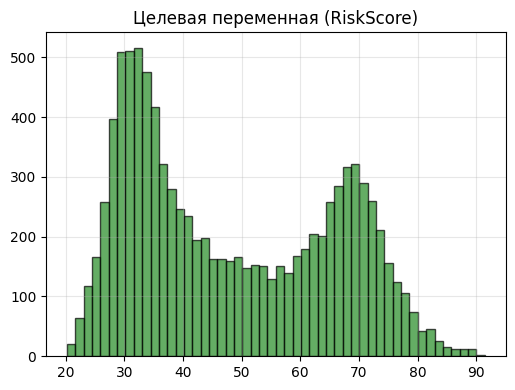

In [ ]:
def load_and_clean_target(train_path, test_path):
    """Загружает данные и проводит очистку целевой переменной."""
    raw_train = pd.read_csv(train_path)
    raw_test = pd.read_csv(test_path)

    print(f"Размерность train: {raw_train.shape}, test: {raw_test.shape}")

    # Удаление пропусков и аномалий в целевой переменной
    df = raw_train.dropna(subset=['RiskScore'])
    
    # Грубая фильтрация
    df = df[(df['RiskScore'] > -100000) & (df['RiskScore'] < 100000)]
    df = df.drop_duplicates()

    # Удаление статистических выбросов
    q_low = df['RiskScore'].quantile(TARGET_CLIP_Q)
    q_high = df['RiskScore'].quantile(1 - TARGET_CLIP_Q)
    df = df[df['RiskScore'].between(q_low, q_high)]

    print(f"Размер после очистки: {len(df)}")
    return df, raw_test

data_train, data_test = load_and_clean_target('data/train.csv', 'data/test.csv')

# Визуализация распределения
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(data_train['RiskScore'], bins=50, color='forestgreen', edgecolor='black', alpha=0.7)
plt.title('Целевая переменная (RiskScore)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Предобработка признаков

In [ ]:
def preprocess_features(df_train, df_test):
    """Базовая предобработка: разделение, кодирование, импутация."""
    target = df_train['RiskScore'].copy()
    
    # Удаление служебных столбцов
    feat_train = df_train.drop(columns=['ApplicationDate', 'RiskScore'], errors='ignore')
    feat_test = df_test.drop(columns=['ID', 'ApplicationDate'], errors='ignore')

    # One-Hot Encoding
    cat_columns = feat_train.select_dtypes(include=['object']).columns
    feat_train = pd.get_dummies(feat_train, columns=cat_columns, drop_first=True)
    feat_test = pd.get_dummies(feat_test, columns=cat_columns, drop_first=True)

    # Выравнивание столбцов
    missing_cols = set(feat_train.columns) - set(feat_test.columns)
    for c in missing_cols:
        feat_test[c] = 0
    feat_test = feat_test[feat_train.columns]

    # Обработка пропусков и выбросов
    for col in feat_train.columns:
        # Заполнение медианой
        if feat_train[col].isnull().any():
            median_val = feat_train[col].median()
            feat_train[col].fillna(median_val, inplace=True)
            feat_test[col].fillna(median_val, inplace=True)
        
        # Клиппинг числовых признаков
        if feat_train[col].dtype in ['float64', 'int64']:
            lower = feat_train[col].quantile(CLIP_LIMITS[0])
            upper = feat_train[col].quantile(CLIP_LIMITS[1])
            feat_train[col] = feat_train[col].clip(lower=lower, upper=upper)
            feat_test[col] = feat_test[col].clip(lower=lower, upper=upper)
            
    return feat_train, feat_test, target

feat_train, feat_test, target_train = preprocess_features(data_train, data_test)
print(f"Признаков после кодирования: {feat_train.shape[1]}")

Признаков после кодирования: 44


## 3. Отбор признаков по корреляции

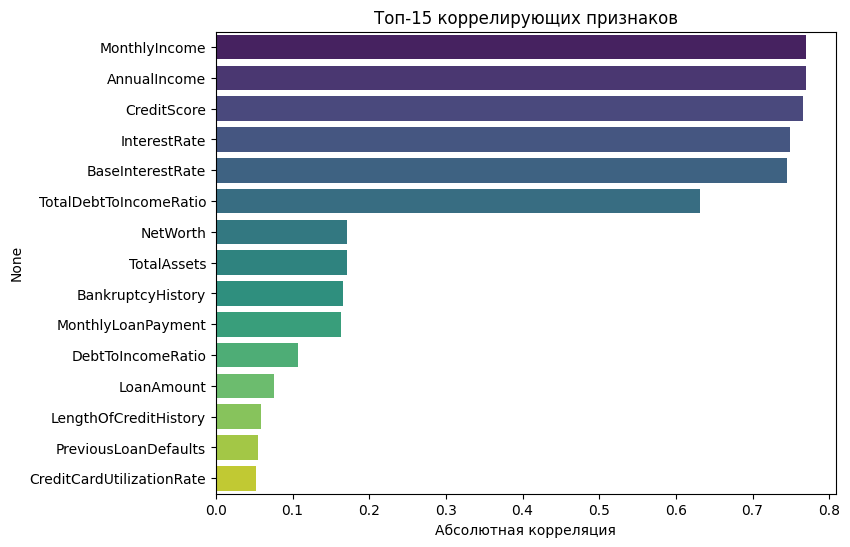

In [ ]:
# Вычисляем корреляции с целевой переменной
corrs = feat_train.corrwith(target_train).abs().sort_values(ascending=False)

# Группы признаков для генерации
top_vars = {
    'sq': corrs.index[:25].tolist(),    # Квадраты
    'cb': corrs.index[:15].tolist(),    # Кубы
    'p4': corrs.index[:5].tolist(),     # 4-я степень
    'pairs': corrs.index[:12].tolist(), # Парные взаимодействия
    'triplets': corrs.index[:5].tolist(), # Тройные взаимодействия
    'sqrt': corrs.index[:10].tolist(),  # Корни
    'inv': corrs.index[:7].tolist()     # Обратные величины
}

# Визуализация топа
plt.figure(figsize=(8, 6))
sns.barplot(x=corrs.head(15).values, y=corrs.head(15).index, palette='viridis')
plt.title('Топ-15 коррелирующих признаков')
plt.xlabel('Абсолютная корреляция')
plt.show()

## 4. Конструирование признаков (Feature Engineering)

In [ ]:
def generate_advanced_features(base_df, feature_groups):
    """Генерация полиномиальных и доменных признаков."""
    new_data = {}
    
    # Полиномиальные признаки
    for col in feature_groups['sq']:
        new_data[f"{col}_sq"] = base_df[col] ** 2
        
    for col in feature_groups['cb']:
        new_data[f"{col}_cube"] = base_df[col] ** 3
        
    for col in feature_groups['p4']:
        new_data[f"{col}_pow4"] = base_df[col] ** 4
        
    # Взаимодействия (Interactions)
    pairs = feature_groups['pairs']
    for i in range(len(pairs)):
        for j in range(i + 1, len(pairs)):
            c1, c2 = pairs[i], pairs[j]
            new_data[f"{c1}_x_{c2}"] = base_df[c1] * base_df[c2]
            
    triplets = feature_groups['triplets']
    for i in range(len(triplets)):
        for j in range(i + 1, len(triplets)):
            for k in range(j + 1, len(triplets)):
                c1, c2, c3 = triplets[i], triplets[j], triplets[k]
                new_data[f"{c1}_x_{c2}_x_{c3}"] = base_df[c1] * base_df[c2] * base_df[c3]
                
    # Математические трансформации
    log_candidates = ['AnnualIncome', 'MonthlyIncome', 'LoanAmount', 'TotalAssets', 
                      'NetWorth', 'CreditScore', 'SavingsAccountBalance', 'CheckingAccountBalance']
    
    for col in log_candidates:
        if col in base_df.columns:
            # log1p(max(x, 0)) защита от отрицательных значений
            new_data[f"{col}_log"] = np.log1p(np.maximum(base_df[col], 0))
            
    for col in feature_groups['sqrt']:
        new_data[f"{col}_sqrt"] = np.sqrt(np.abs(base_df[col]))
        
    for col in feature_groups['inv']:
        new_data[f"{col}_inv"] = 1 / (np.abs(base_df[col]) + 1)
        
    # Доменные (финансовые) отношения
    # Используем .get для безопасного доступа, если каких-то колонок нет
    def safe_col(name): return base_df[name] if name in base_df.columns else pd.Series(0, index=base_df.index)
    
    ann_inc = safe_col('AnnualIncome')
    mon_inc = safe_col('MonthlyIncome')
    new_data['income_consistency'] = ann_inc / (mon_inc * 12 + 1)
    new_data['credit_per_age'] = safe_col('CreditScore') / (safe_col('Age') + 1)
    new_data['loan_to_income'] = safe_col('LoanAmount') / (ann_inc + 1)
    new_data['liability_ratio'] = safe_col('TotalLiabilities') / (safe_col('TotalAssets') + 1)
    new_data['wealth_per_age'] = safe_col('NetWorth') / (safe_col('Age') + 1)
    new_data['payment_to_income'] = safe_col('MonthlyLoanPayment') / (mon_inc + 1)

    # Сбрасываем индекс, чтобы эмулировать поведение .values в оригинале
    return pd.DataFrame(new_data).reset_index(drop=True)

# Применяем генерацию
print("Генерация признаков...")
extra_train = generate_advanced_features(feat_train, top_vars)
extra_test = generate_advanced_features(feat_test, top_vars)

# Объединение и сброс индекса (для репликации логики оригинала)
# feat_train сбрасываем индекс, extra_train уже сброшен
feat_train_full = pd.concat([feat_train.reset_index(drop=True), extra_train], axis=1)
feat_test_full = pd.concat([feat_test.reset_index(drop=True), extra_test], axis=1)

print(f"Всего признаков: {feat_train_full.shape[1]}")

Генерация признаков...
Всего признаков: 196


## 5. Постобработка и очистка

In [ ]:
def clean_generated_features(df_tr, df_te, target, corr_threshold=0.995):
    """Удаление inf, nan и мультиколлинеарных признаков."""
    # Замена бесконечностей и пропусков
    df_tr.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_te.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    for col in df_tr.columns:
        if df_tr[col].isnull().any():
            med = df_tr[col].median()
            med = 0 if pd.isna(med) else med
            df_tr[col].fillna(med, inplace=True)
            df_te[col].fillna(med, inplace=True)
            
    # Удаление мультиколлинеарности
    corr_matrix = df_tr.corr()
    drop_set = set()
    cols = corr_matrix.columns
    
    # Проходим по верхнему треугольнику матрицы корреляций
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            if abs(corr_matrix.iloc[i, j]) > corr_threshold:
                col_a, col_b = cols[i], cols[j]
                # Оставляем тот, который сильнее коррелирует с целевой переменной
                corr_a = abs(df_tr[col_a].corr(target))
                corr_b = abs(df_tr[col_b].corr(target))
                drop_set.add(col_b if corr_a >= corr_b else col_a)
    
    if drop_set:
        print(f"Удалено {len(drop_set)} мультиколлинеарных признаков")
        df_tr.drop(columns=drop_set, inplace=True)
        df_te.drop(columns=drop_set, inplace=True)
        
    return df_tr, df_te

feat_train_clean, feat_test_clean = clean_generated_features(
    feat_train_full, feat_test_full, target_train, CORRELATION_LIMIT
)

print(f"Итоговое количество признаков: {feat_train_clean.shape[1]}")

Удалено 42 мультиколлинеарных признаков
Итоговое количество признаков: 154


## 6. Масштабирование и Моделирование

In [ ]:
# Масштабирование
scaler = RobustScaler()
X_scaled = scaler.fit_transform(feat_train_clean)
X_test_scaled = scaler.transform(feat_test_clean)

# Разделение на валидацию
X_tr, X_val, y_tr, y_val = train_test_split(
    X_scaled, target_train, test_size=VAL_FRAC, random_state=SEED
)

# Обучение модели
model = LinearRegression()
model.fit(X_tr, y_tr)

# Оценка качества
preds_val = model.predict(X_val)
mse = mean_squared_error(y_val, preds_val)
mae = mean_absolute_error(y_val, preds_val)
r2 = r2_score(y_val, preds_val)

print("\n" + "-"*30)
print("Результаты валидации:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {np.sqrt(mse):.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2:   {r2:.4f}")
print("-"*30)


------------------------------
Результаты валидации:
MSE:  25.4084
RMSE: 5.0407
MAE:  3.7475
R2:   0.9149
------------------------------


## 7. Финальный прогноз

Прогноз: min=15.96, max=96.21, mean=48.18


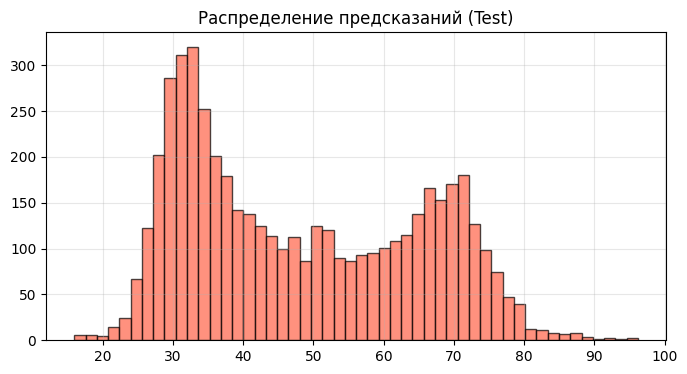

Файл submission.csv успешно создан.


In [ ]:
# Обучение на всех данных
model.fit(X_scaled, target_train)
final_preds = model.predict(X_test_scaled)

# Анализ прогноза
print(f"Прогноз: min={final_preds.min():.2f}, max={final_preds.max():.2f}, mean={final_preds.mean():.2f}")

plt.figure(figsize=(8, 4))
plt.hist(final_preds, bins=50, color='tomato', edgecolor='black', alpha=0.7)
plt.title('Распределение предсказаний (Test)')
plt.grid(True, alpha=0.3)
plt.show()

# Сохранение результата
submission = pd.DataFrame({
    'ID': data_test['ID'],
    'RiskScore': final_preds
})
submission.to_csv('submission.csv', index=False)
print("Файл submission.csv успешно создан.")